<a href="https://colab.research.google.com/github/Sshubam/PyTorch-Code/blob/main/PyTorch_14_Predicting_Stock_returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import figure
from pylab import rcParams

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [ ]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [ ]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


# "Price"

In [ ]:
series = df['close'].values.reshape(-1, 1)

In [ ]:
series

array([[28.185],
       [28.07 ],
       [28.13 ],
       ...,
       [54.69 ],
       [55.61 ],
       [54.46 ]])

In [ ]:
##Doing it the wrong way first
scaler = StandardScaler() 
scaler.fit(series[:len(series)// 2])         #Compute the mean and std. to be used for later scaling.
series = scaler.transform(series).flatten()  #Perform standardization by centering and scaling

In [ ]:
#Using past T values to predict the next values
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1239, 20, 1) Y.shape (1239, 1)


In [ ]:
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers = self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)  #hidden state has shape (num_layers * num_directions, batch, hidden_size) .
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, _ = self.rnn(X, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
model = RNN(1, 5, 1, 1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer =  torch.optim.Adam(model.parameters(),  lr=0.1)

In [ ]:
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  train_losses =  np.zeros(epochs)
  test_losses  = np.zeros(epochs)

  for it in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses[it] = loss.item()
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it+1) % 5 == 0:
      print(f"Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss, {test_loss.item():.4f}")

  return train_losses, test_losses

In [ ]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
X_train, y_train  = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.2444, Test Loss, 1.1940
Epoch 10/200, Train Loss: 0.0436, Test Loss, 0.2863
Epoch 15/200, Train Loss: 0.0157, Test Loss, 0.0997
Epoch 20/200, Train Loss: 0.0148, Test Loss, 0.0324
Epoch 25/200, Train Loss: 0.0134, Test Loss, 0.0312
Epoch 30/200, Train Loss: 0.0104, Test Loss, 0.0322
Epoch 35/200, Train Loss: 0.0074, Test Loss, 0.0459
Epoch 40/200, Train Loss: 0.0066, Test Loss, 0.0264
Epoch 45/200, Train Loss: 0.0065, Test Loss, 0.0327
Epoch 50/200, Train Loss: 0.0063, Test Loss, 0.0387
Epoch 55/200, Train Loss: 0.0063, Test Loss, 0.0321
Epoch 60/200, Train Loss: 0.0061, Test Loss, 0.0306
Epoch 65/200, Train Loss: 0.0059, Test Loss, 0.0272
Epoch 70/200, Train Loss: 0.0058, Test Loss, 0.0296
Epoch 75/200, Train Loss: 0.0058, Test Loss, 0.0267
Epoch 80/200, Train Loss: 0.0057, Test Loss, 0.0298
Epoch 85/200, Train Loss: 0.0056, Test Loss, 0.0278
Epoch 90/200, Train Loss: 0.0056, Test Loss, 0.0275
Epoch 95/200, Train Loss: 0.0056, Test Loss, 0.0260
Epoch 100/200

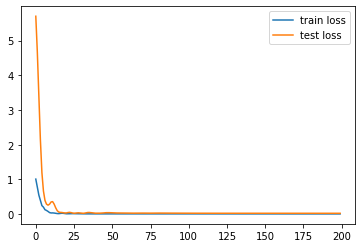

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [ ]:
X.shape

(1239, 20, 1)

In [ ]:
#ONE STEP FORECAST
validation_target = Y
validation_predictions = []
i = 0
X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1, T, 1)
  p = model(input_)[0, 0].item()
  i += 1

  validation_predictions.append(p)

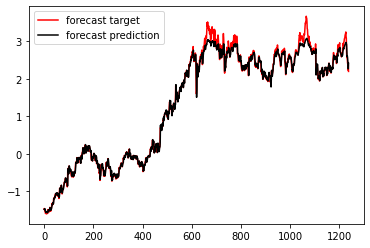

In [ ]:
plt.plot(validation_target, label = "forecast target", color = "red")
plt.plot(validation_predictions, label = "forecast prediction", color = "black")
plt.legend()

In [ ]:
#MULTI STEP FORECAST
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  validation_predictions.append(p[0, 0].item())
  last_x = torch.cat((last_x[1:], p[0]))

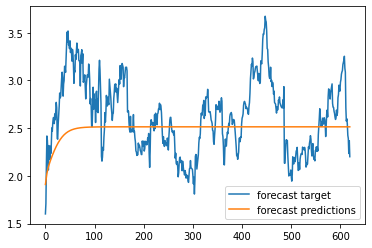

In [ ]:
plt.plot(validation_target, label = "forecast target")
plt.plot(validation_predictions, label = "forecast predictions")
plt.legend()
#not doing even "good" because it becomes a smooth function, now rather than predicting the stocks prices we are going to predict the stock return which is (final value - inital value) / (initial value)

# "Returns"

In [ ]:
df['PrevClose'] = df['close'].shift(1)
#makes data like
#close/prevclose
#x[2] x[1]
#x[3] x[2]
#x[4] x[3]
#x[t] x[t-1]

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [ ]:
#Calculate the return i.e. (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [ ]:
df

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015
...,...,...,...,...,...,...,...,...,...
1254,2018-02-01,56.280,56.420,55.890,56.000,14690146,SBUX,56.810,-0.014258
1255,2018-02-02,55.900,56.320,55.700,55.770,15358909,SBUX,56.000,-0.004107
1256,2018-02-05,55.530,56.260,54.570,54.690,16059955,SBUX,55.770,-0.019365
1257,2018-02-06,53.685,56.060,53.560,55.610,17415065,SBUX,54.690,0.016822


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


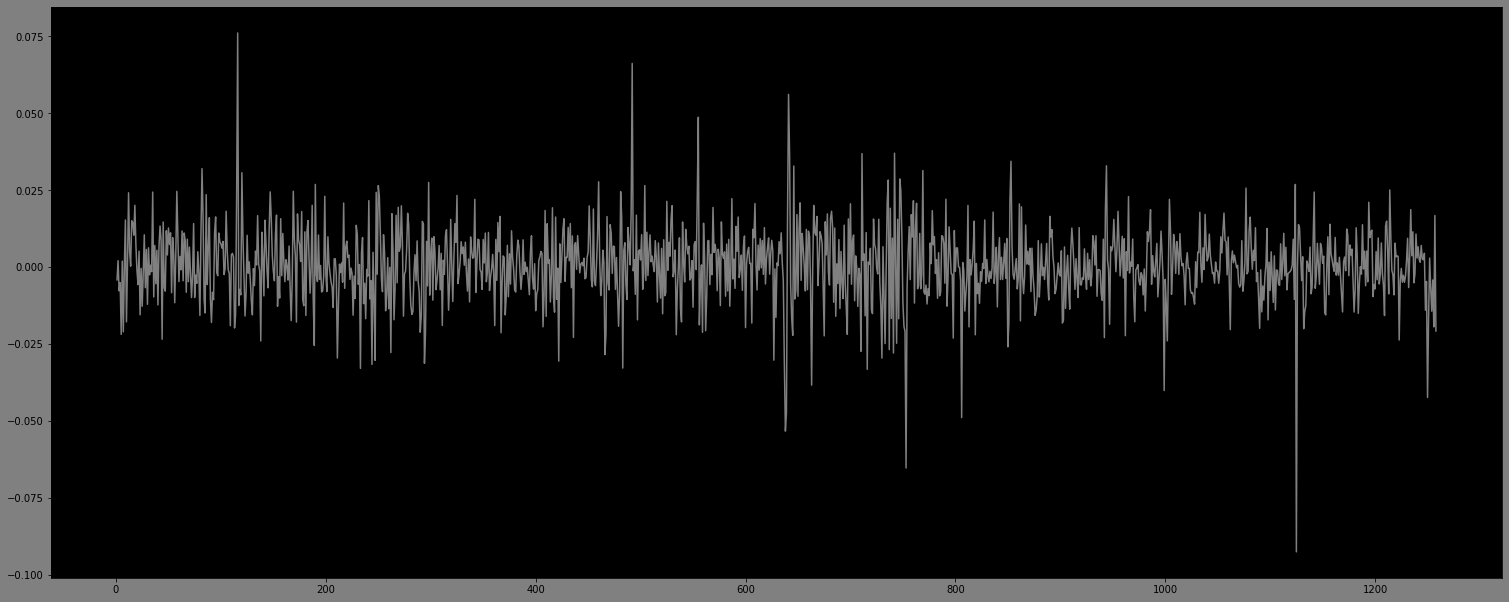

In [ ]:
fig = plt.plot(df['Return'], color = "grey")
fig = plt.gcf()
fig.set_size_inches(26, 10.5)  #(width, height) 
fig.savefig('test2png.png', dpi=1200)
ax = plt.axes()
# Setting the background color of the plot 
# using set_facecolor() method
ax.set_facecolor("black")
fig.patch.set_facecolor('grey')

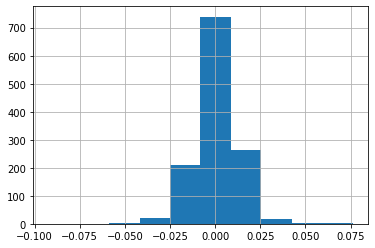

In [ ]:
df['Return'].hist()

In [ ]:
series =  df["Return"].values[1:].reshape(-1, 1)  #used [:1] to exclude first value i.e. NaN
#Normalisation of data:
scaler = StandardScaler()
scaler.fit(series[:len(series) //  2])
series = scaler.transform(series).flatten()

In [ ]:
series.shape

(1258,)

In [ ]:
series

array([-0.43811722,  0.08061497, -0.73536414, ..., -1.71332483,
        1.30572463, -1.82299002])

In [ ]:
#using T past values to predict the next  value
T =  20
D = 1
X  = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y =series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N =len(X)
print("X.shape", X.shape, "Y>shape", Y.shape)

X.shape (1238, 20, 1) Y>shape (1238, 1)


In [ ]:
series[t:t+T]

array([-0.28057855,  0.80451856,  0.15332391,  0.4584747 ,  0.12328801,
        0.04004724,  0.4936835 ,  0.13444845,  0.10656673,  0.28267879,
       -1.26076122, -0.48173418, -3.6249899 , -1.49322183,  0.15101987,
       -0.65205532, -1.28723988, -0.44036631, -1.71332483,  1.30572463])

In [ ]:
series[t:t+T+1]

array([-0.28057855,  0.80451856,  0.15332391,  0.4584747 ,  0.12328801,
        0.04004724,  0.4936835 ,  0.13444845,  0.10656673,  0.28267879,
       -1.26076122, -0.48173418, -3.6249899 , -1.49322183,  0.15101987,
       -0.65205532, -1.28723988, -0.44036631, -1.71332483,  1.30572463,
       -1.82299002])

In [ ]:
series[t+T]

-1.8229900184564862

In [ ]:
model = RNN(1, 5, 1, 1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 1.0527, Test Loss, 1.0632
Epoch 10/200, Train Loss: 1.0516, Test Loss, 1.0643
Epoch 15/200, Train Loss: 1.0472, Test Loss, 1.0743
Epoch 20/200, Train Loss: 1.0440, Test Loss, 1.0718
Epoch 25/200, Train Loss: 1.0414, Test Loss, 1.0690
Epoch 30/200, Train Loss: 1.0391, Test Loss, 1.0792
Epoch 35/200, Train Loss: 1.0378, Test Loss, 1.0817
Epoch 40/200, Train Loss: 1.0361, Test Loss, 1.0816
Epoch 45/200, Train Loss: 1.0343, Test Loss, 1.0878
Epoch 50/200, Train Loss: 1.0328, Test Loss, 1.0896
Epoch 55/200, Train Loss: 1.0313, Test Loss, 1.0918
Epoch 60/200, Train Loss: 1.0294, Test Loss, 1.0961
Epoch 65/200, Train Loss: 1.0272, Test Loss, 1.0973
Epoch 70/200, Train Loss: 1.0247, Test Loss, 1.0998
Epoch 75/200, Train Loss: 1.0219, Test Loss, 1.1014
Epoch 80/200, Train Loss: 1.0185, Test Loss, 1.1036
Epoch 85/200, Train Loss: 1.0143, Test Loss, 1.1079
Epoch 90/200, Train Loss: 1.0087, Test Loss, 1.1139
Epoch 95/200, Train Loss: 1.0011, Test Loss, 1.1272
Epoch 100/200

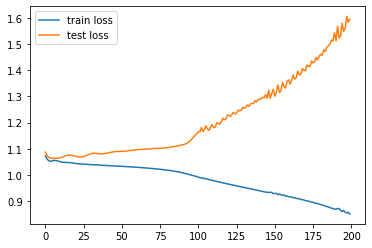

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [ ]:
#Single step forecast
validation_target = Y
validation_predictions = []
i = 0
X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1, T, 1)
  p =model(input_)[0, 0].item()
  i += 1

  validation_predictions.append(p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


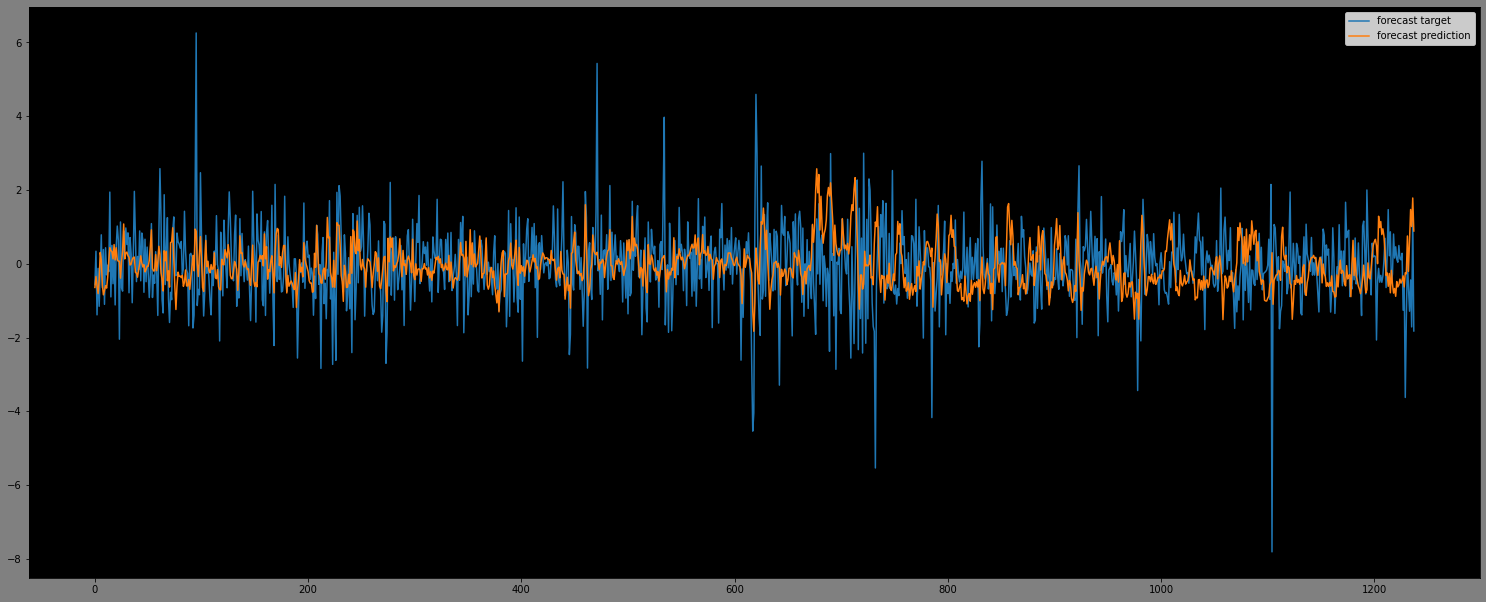

In [ ]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(26, 10.5)  #(width, height) 
fig.savefig('test2png.png', dpi=1200)
ax = plt.axes()
ax.set_facecolor("black")
fig.patch.set_facecolor('grey')

In [ ]:
#Multi step forecast
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  validation_predictions.append(p[0, 0].item())
  last_x = torch.cat((last_x[1:], p[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


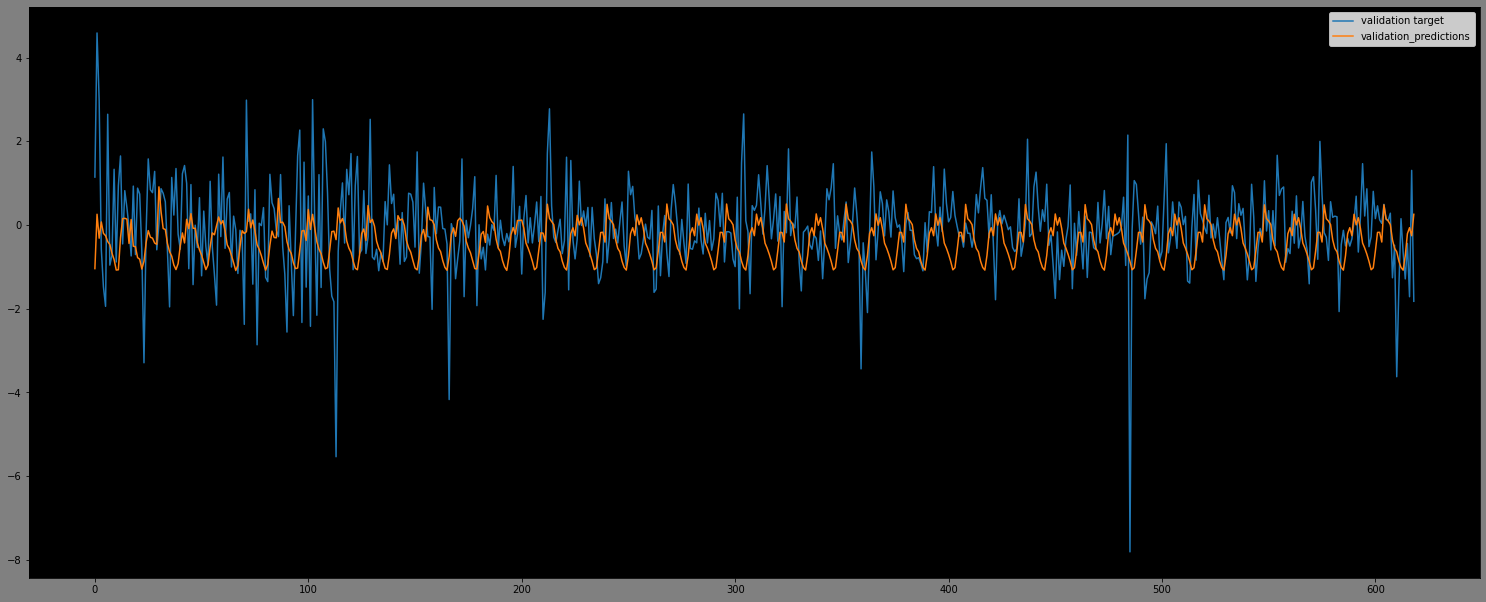

In [ ]:
plt.plot(validation_target, label="validation target")
plt.plot(validation_predictions, label="validation_predictions")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(26, 10.5)  #(width, height) 
fig.savefig('test2png.png', dpi=1200)
ax = plt.axes()
ax.set_facecolor("black")
fig.patch.set_facecolor('grey')

# Binary Classification

In [ ]:
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [ ]:
input_data.shape[1]

5

In [ ]:
len(input_data)

1259

In [ ]:
T = 10 #number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [ ]:
Ntrain = len(input_data) * 2 // 3  #two thirds of the data is training set and one third is test set
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [ ]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)  #whether Return is positive or not

In [ ]:
N - Ntrain

410

In [ ]:
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):  # N-Ntrain = test data
  #t counts from Ntrain to N
  # u counts from 0 to (N -Ntrain)
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [ ]:
model = RNN(5, 50, 2, 1)
model.to(device)

RNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=300)

Epoch 5/300, Train Loss: 0.6915, Test Loss, 0.6935
Epoch 10/300, Train Loss: 0.6891, Test Loss, 0.6928
Epoch 15/300, Train Loss: 0.6889, Test Loss, 0.6909
Epoch 20/300, Train Loss: 0.6839, Test Loss, 0.6922
Epoch 25/300, Train Loss: 0.6823, Test Loss, 0.7042
Epoch 30/300, Train Loss: 0.6773, Test Loss, 0.7069
Epoch 35/300, Train Loss: 0.6723, Test Loss, 0.7039
Epoch 40/300, Train Loss: 0.6635, Test Loss, 0.7220
Epoch 45/300, Train Loss: 0.6476, Test Loss, 0.7376
Epoch 50/300, Train Loss: 0.6300, Test Loss, 0.7882
Epoch 55/300, Train Loss: 0.6095, Test Loss, 0.7768
Epoch 60/300, Train Loss: 0.5934, Test Loss, 0.8425
Epoch 65/300, Train Loss: 0.5706, Test Loss, 0.9140
Epoch 70/300, Train Loss: 0.5368, Test Loss, 0.9571
Epoch 75/300, Train Loss: 0.5006, Test Loss, 0.9665
Epoch 80/300, Train Loss: 0.4576, Test Loss, 1.1276
Epoch 85/300, Train Loss: 0.4798, Test Loss, 1.2758
Epoch 90/300, Train Loss: 0.4209, Test Loss, 1.3397
Epoch 95/300, Train Loss: 0.3698, Test Loss, 1.4094
Epoch 100/300

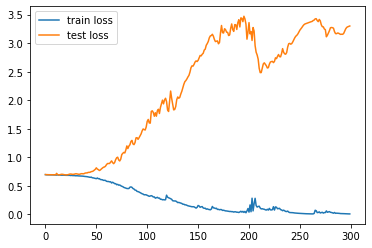

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()
#welllllll none of these worked in a good way, ~50% accuracy.Can't predict the future ;)